# **Import library**

In [ ]:
!pip install sastrawi

In [ ]:
!pip install wordcloud

In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# **Load Dataset**
pada tahapan ini dataset yang digunakan merupakan dataset hasil preprocessing komen [youtube](https://youtu.be/F3gyEBRi40I?si=9IhCwpmoYO5Euv_W) yang diambil menggunakan teknik scrawling

In [ ]:
#Ini load data dengan encode latin-1 karena file diedit di excell dan di trasnform ke csv untuk membaca
#perlu menambahkan encode ke UTF8
data = pd.read_csv('/content/drive/MyDrive/Data Meaning Dinar 3022310034/UAS Sentiment Analysis/data-clean.csv', encoding='latin1')
data.head()

,Date,comment,text_clean,like,Label
0,2026-01-09T12:11:50Z,Cuma berani sama negara kecil??,berani negara,0,Negatif
1,2026-01-09T11:18:23Z,Rakyat venezuela sudah muak sama presidennya y...,rakyat venezuela muak presiden korup negara mi...,0,Negatif
2,2026-01-09T10:50:01Z,Amerika pikir2 mau nyerang indonesia karna di ...,amerika pikir2 nyerang indonesia karna tni pas...,0,Netral
3,2026-01-09T09:59:59Z,Ini tindakan invasi,tindak invasi,0,Negatif
4,2026-01-09T05:14:54Z,"Apakah presiden Venezuela akan di hukum mati, ...",presiden venezuela hukum mati halny presiden irak,0,Netral


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Dataset yang digunakan dalam penelitian ini berjumlah 1.516 komentar YouTube yang telah melalui tahap prapemrosesan teks. Dari keseluruhan dataset tersebut, sebanyak 200 komentar diberi label sentimen secara manual dan digunakan sebagai data latih serta data uji dalam proses pemodelan analisis sentimen. Jumlah data berlabel tersebut dipilih karena dinilai telah mencukupi untuk merepresentasikan karakteristik bahasa dan sentimen pada data komentar, sedangkan komentar lainnya dimanfaatkan sebagai data tidak berlabel untuk proses prediksi sentimen.*

In [ ]:
data_cleaned = data.drop(columns=['Date', 'comment', 'like'])
display(data_cleaned.head())

,text_clean,Label
0,berani negara,Negatif
1,rakyat venezuela muak presiden korup negara mi...,Negatif
2,amerika pikir2 nyerang indonesia karna tni pas...,Netral
3,tindak invasi,Negatif
4,presiden venezuela hukum mati halny presiden irak,Netral


*pada tahapan ini menghapus variabel/kolom yang tidak diperlukan pada tahapan analisis*

# **Analysis sentimen**

In [ ]:
#Cek data Kosong
print(data.isnull().sum())


Date             0
comment          0
text_clean      10
like             0
Label         1317
dtype: int64


In [ ]:
#Menghapus baris kodong
data = data.dropna(subset=['text_clean', 'comment'])

In [ ]:
#Cek data Kosong
print(data.isnull().sum())

Date             0
comment          0
text_clean       0
like             0
Label         1307
dtype: int64


In [ ]:
#data berlabel
labeled_data = data.dropna(subset=['Label']).copy()
#data tidak berlabel
unlabeled_data = data[data['Label'].isna()].copy()

print("Jumlah data berlabel:", labeled_data.shape[0])
print("Jumlah data tidak berlabel:", unlabeled_data.shape[0])

Jumlah data berlabel: 200
Jumlah data tidak berlabel: 1307


**Split data train dan test**

*pada tahapan ini dilakukan dengan menggunakan Stratified split karena data yang digunakan hanya 200 dari 1317 data yang ada di dataset*

In [ ]:
labeled_data = data.dropna(subset=['Label']).copy()

# Check value counts to identify classes with only one member
label_counts = labeled_data['Label'].value_counts()
single_sample_classes = label_counts[label_counts == 1].index

# Filter out rows belonging to classes with only one sample
if not single_sample_classes.empty:
    labeled_data = labeled_data[~labeled_data['Label'].isin(single_sample_classes)]
    print(f"Removed {len(single_sample_classes)} classes with only one sample: {single_sample_classes.tolist()}")

X = labeled_data['text_clean']
y = labeled_data['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Removed 1 classes with only one sample: ['Sentimen']


**TF-IDF Vectorization**

*pada tahapan ini digunakan untuk mengubah data teks menjadi representasi numerik agar dapat diproses oleh algoritma machine learning.*

In [ ]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_df=0.9,
    min_df=2
)

X_train_tfidf = vectorizer.fit_transform(X_train.fillna(''))
X_test_tfidf  = vectorizer.transform(X_test.fillna(''))

# **Train Model**

**Logic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)
model.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

Prediksi data uji

In [ ]:
y_pred = model.predict(X_test_tfidf)

Evaluasi model

In [ ]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

     Negatif       0.70      0.70      0.70        27
      Netral       0.36      0.40      0.38        10
     Positif       0.00      0.00      0.00         3

    accuracy                           0.57        40
   macro avg       0.36      0.37      0.36        40
weighted avg       0.57      0.57      0.57        40



In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.575


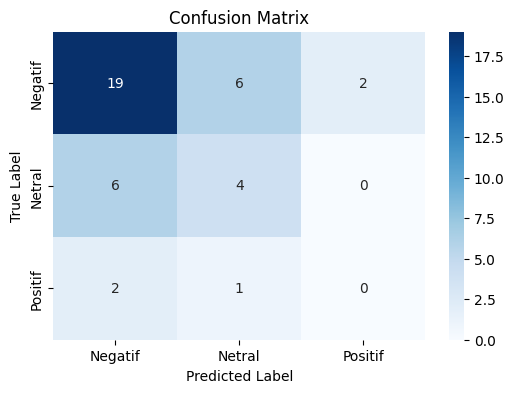

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=model.classes_,
    yticklabels=model.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [ ]:
y_pred_nb = nb_model.predict(X_test_tfidf)

In [ ]:
print(classification_report(y_test, y_pred_nb))


              precision    recall  f1-score   support

     Negatif       0.68      1.00      0.81        27
      Netral       0.00      0.00      0.00        10
     Positif       0.00      0.00      0.00         3

    accuracy                           0.68        40
   macro avg       0.23      0.33      0.27        40
weighted avg       0.46      0.68      0.54        40



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy Naive Bayes:", accuracy_nb)

Accuracy Naive Bayes: 0.675


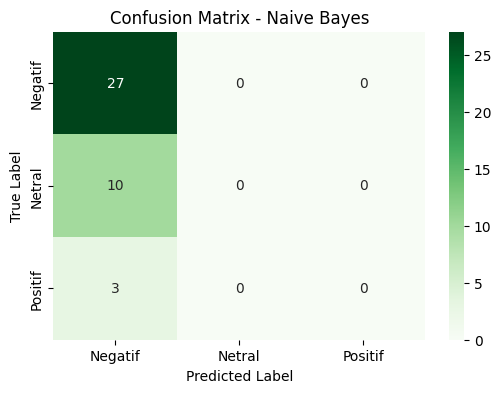

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_nb,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=nb_model.classes_,
    yticklabels=nb_model.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()


**SVM**

In [ ]:
from sklearn.svm import LinearSVC

Training model SVM

In [ ]:
svm_model = LinearSVC(
    class_weight='balanced',
    random_state=42
)

svm_model.fit(X_train_tfidf, y_train)

LinearSVC(class_weight='balanced', random_state=42)

Prediksi data uji

In [ ]:
y_pred_svm = svm_model.predict(X_test_tfidf)

Evaluasi

In [ ]:
print(classification_report(y_test, y_pred_svm))


              precision    recall  f1-score   support

     Negatif       0.68      0.78      0.72        27
      Netral       0.43      0.30      0.35        10
     Positif       0.00      0.00      0.00         3

    accuracy                           0.60        40
   macro avg       0.37      0.36      0.36        40
weighted avg       0.56      0.60      0.58        40



In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy Linear SVM:", accuracy_svm)

Accuracy Linear SVM: 0.6


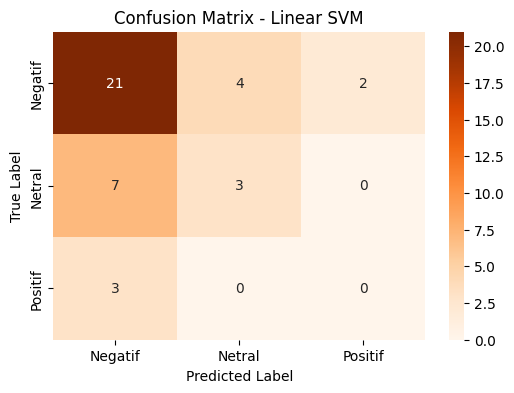

In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm_svm,
    annot=True,
    fmt='d',
    cmap='Oranges',
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Linear SVM')
plt.show()

#**PERBANDINGAN AKURASI MODEL ML**

In [ ]:
print("\nPERBANDINGAN AKURASI MODEL\n")
print(f"Logistic Regression : {accuracy:.4f}")
print(f"Naive Bayes         : {accuracy_nb:.4f}")
print(f"Linear SVM          : {accuracy_svm:.4f}")


PERBANDINGAN AKURASI MODEL

Logistic Regression : 0.5750
Naive Bayes         : 0.6750
Linear SVM          : 0.6000


*Berdasarkan hasil evaluasi, Naive Bayes dan Deep Learning menunjukkan performa tertinggi dengan nilai akurasi sebesar 77,5%. Namun, Naive Bayes dipilih sebagai model akhir karena lebih sesuai untuk dataset berukuran kecil dan memiliki kompleksitas yang lebih rendah.*

*Berdasarkan hasil prediksi model Naive Bayes terhadap seluruh data komentar, diperoleh bahwa sentimen negatif lebih dominan dibandingkan sentimen netral dan positif.*

Prediksi data tanpa label

In [ ]:
if not unlabeled_data.empty:
    X_unlabeled_tfidf = vectorizer.transform(
        unlabeled_data['text_clean'].fillna('')
    )

    unlabeled_data['Predicted_Label'] = nb_model.predict(X_unlabeled_tfidf)
    print("Prediksi data tanpa label berhasil menggunakan Naive Bayes.")
else:
    print("Tidak ada data tanpa label.")

Prediksi data tanpa label berhasil menggunakan Naive Bayes.


In [ ]:
# Gabungkan data berlabel & hasil prediksi
final_data = pd.concat([labeled_data, unlabeled_data], axis=0)

final_data.head()


,Date,comment,text_clean,like,Label,Predicted_Label
0,2026-01-09T12:11:50Z,Cuma berani sama negara kecil??,berani negara,0,Negatif,NaN
1,2026-01-09T11:18:23Z,Rakyat venezuela sudah muak sama presidennya y...,rakyat venezuela muak presiden korup negara mi...,0,Negatif,NaN
2,2026-01-09T10:50:01Z,Amerika pikir2 mau nyerang indonesia karna di ...,amerika pikir2 nyerang indonesia karna tni pas...,0,Netral,NaN
3,2026-01-09T09:59:59Z,Ini tindakan invasi,tindak invasi,0,Negatif,NaN
4,2026-01-09T05:14:54Z,"Apakah presiden Venezuela akan di hukum mati, ...",presiden venezuela hukum mati halny presiden irak,0,Netral,NaN


In [ ]:
final_data = pd.concat([labeled_data, unlabeled_data], ignore_index=True)

In [ ]:
final_data['Final_Label'] = final_data['Label']

final_data.loc[
    final_data['Final_Label'].isna(),
    'Final_Label'
] = final_data['Predicted_Label']


In [ ]:
final_data[['Label', 'Predicted_Label', 'Final_Label']].head(10)

,Label,Predicted_Label,Final_Label
0,Negatif,NaN,Negatif
1,Negatif,NaN,Negatif
2,Netral,NaN,Netral
3,Negatif,NaN,Negatif
4,Netral,NaN,Netral
5,Negatif,NaN,Negatif
6,Negatif,NaN,Negatif
7,Netral,NaN,Netral
8,Negatif,NaN,Negatif
9,Netral,NaN,Netral


In [ ]:
final_data['Final_Label'].value_counts(normalize=True) * 100

,proportion
Final_Label,
Negatif,93.891102
Netral,5.179283
Positif,0.929615


In [ ]:
final_data[final_data['Label'].isna()][
    ['text_clean', 'Predicted_Label']
].sample(10, random_state=42)

,text_clean,Predicted_Label
1363,hukum karma laku trump keluarga mutilasi orang,Negatif
1246,alas amerika berani ganggu negara2 coba china ...,Negatif
992,mrasyidsupriyadi3832 tuju tindak amerika seran...,Negatif
1256,karna minyak,Negatif
921,narkoba ganja dll legal knpa tangkap,Negatif
439,mafia pemculikann sengaja laku negara,Negatif
1315,begetulah amrik negara bar quot coba klw sirew...,Negatif
986,langgar ham jajah nama amerika langgar tindak ...,Negatif
1480,grassberg sdh bolong siap2 waspada telat mendi...,Negatif
264,cere2 doang amerika brani khan diincer minyak ...,Negatif


In [ ]:
final_data.groupby(
    final_data['Label'].notna()
)['Final_Label'].value_counts(normalize=True)

Label  Final_Label
False  Negatif        0.977812
       Netral         0.022188
True   Negatif        0.683417
       Netral         0.246231
       Positif        0.070352
Name: proportion, dtype: float64